In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point, LineString, LinearRing, Polygon, box
from shapely import union_all
from shapely.ops import voronoi_diagram


In [2]:
!pip install geopandas
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.8 MB/s eta 0:00:00


In [3]:
import geopandas as gpd

Existing code * New household data with same parks/grocery*

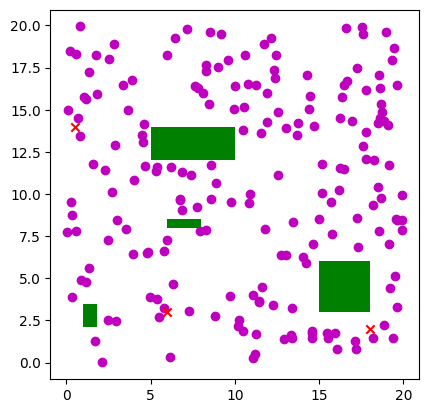

In [63]:
rng = np.random.default_rng(seed=0)
n_total = 200
xmin, xmax, ymin, ymax = 0, 20, 0, 20 
hx = rng.uniform(xmin,xmax,n_total)
hy = rng.uniform(ymin,ymax,n_total)
households = [Point(x, y) for x,y in zip(hx,hy)]

parks = [ box(5, 12, 10, 14) ,box(1, 2.1, 1.8, 3.5),  box(6, 8, 8, 8.5), box(15, 3, 18, 6) ]
grocery =  [Point(18,2), Point(6,3),Point(0.5,14)]


households = [hh.difference(union_all(parks)) for hh in households]
households = [hh for hh in households if not hh.is_empty ]

ax1 = gpd.GeoSeries(parks).plot(color='g')
gpd.GeoSeries(households).plot(ax=ax1,color='m')
gpd.GeoSeries(grocery).plot(ax=ax1,color='r',marker='x')

p = np.array([28.45,35.03,15.03,12.39,5.83,2.03,1.24])/100
p[-1] += 1 - np.sum(p) 
household_size = rng.choice(np.linspace(1,7,7),size=len(households),p=p)

house_df = gpd.GeoDataFrame({'hh_size':household_size, 'geometry': households})
house_df['dist_park'] = house_df.distance(union_all(parks))
house_df['dist_grocery'] = house_df.distance(union_all(grocery))
house_df['satisfied_index'] =  1/(1+house_df['dist_park']) + 1/(1+house_df['dist_grocery'])



In [64]:
regions = voronoi_diagram(union_all(grocery)).geoms
grocery_df = gpd.GeoDataFrame({'index': range(len(grocery)), 'geometry': regions})
print(grocery_df)

   index                                           geometry
0      0  POLYGON ((-17.00000 31.50000, 25.36429 31.5000...
1      1  POLYGON ((35.50000 31.50000, 35.50000 -15.5000...
2      2  POLYGON ((-17.00000 -15.50000, -17.00000 -1.62...


In [65]:
merged =  grocery_df.sjoin(house_df, how="right",predicate="intersects")
print(merged)
print(merged.shape)
house_df["grocery_index"] = merged["index_left"]
house_df.head()

     index_left  index  hh_size                   geometry  dist_park  \
0             1      1      1.0   POINT (12.73923 6.39363)   2.294779   
1             2      2      5.0    POINT (5.39573 3.75015)   3.604425   
2             0      0      1.0   POINT (0.81947 13.45053)   4.180530   
3             2      2      1.0    POINT (0.33055 3.90215)   0.780950   
4             1      1      2.0  POINT (16.26540 11.55376)   5.553758   
..          ...    ...      ...                        ...        ...   
187           2      2      1.0   POINT (11.42791 3.58125)   3.572088   
188           0      0      1.0   POINT (0.12818 14.96449)   4.966375   
189           1      1      2.0   POINT (15.45298 1.73363)   1.266374   
190           1      1      5.0   POINT (19.56531 8.51712)   2.964140   
191           2      2      2.0   POINT (11.79740 7.93504)   3.741793   

     dist_grocery  satisfied_index  
0        6.854172         0.430831  
1        0.963259         0.726539  
2        0.6

,hh_size,geometry,dist_park,dist_grocery,satisfied_index,grocery_index
0,1.0,POINT (12.73923 6.39363),2.294779,6.854172,0.430831,1
1,5.0,POINT (5.39573 3.75015),3.604425,0.963259,0.726539,2
2,1.0,POINT (0.81947 13.45053),4.180530,0.635591,0.804430,0
3,1.0,POINT (0.33055 3.90215),0.780950,5.740776,0.709849,2
4,2.0,POINT (16.26540 11.55376),5.553758,9.709949,0.245955,1


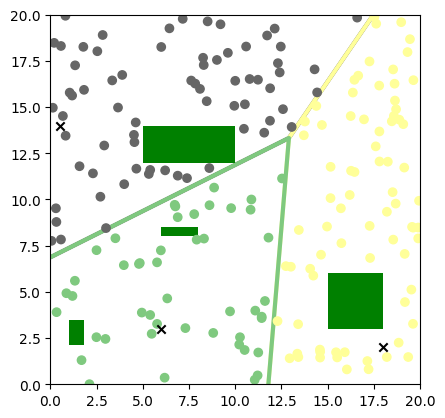

In [66]:
ax1 = grocery_df.plot(column="index",facecolor="none",linewidth=3,cmap='Accent_r')
gpd.GeoSeries(parks).plot(ax=ax1,color='g')
house_df.plot(ax=ax1,column="grocery_index",cmap='Accent_r')
gpd.GeoSeries(grocery).plot(ax=ax1,color='k',marker='x')
plt.axis([xmin, xmax, ymin, ymax])
plt.show()

In [86]:
merged['hh'] =1
hh_dissolved = merged.dissolve(by="index_left",
                                           aggfunc={
                                               "hh":"sum",
                                               "satisfied_index":"median",
                                               "hh_size":"mean"
                                           })
print(hh_dissolved)
hh_dissolved['pop'] = hh_dissolved.apply(lambda x: (x.hh_size* x.hh), axis=1)
print(hh_dissolved['pop'].shape)
house_df['pop']=hh_dissolved.loc[house_df.grocery_index,'pop'].values
print(house_df)

                                                     geometry  hh  \
index_left                                                          
0           MULTIPOINT (0.05477 7.76133, 0.12818 14.96449,...  69   
1           MULTIPOINT (12.28746 3.42043, 12.73923 6.39363...  76   
2           MULTIPOINT (0.33055 3.90215, 0.86134 4.92812, ...  47   

            satisfied_index   hh_size  
index_left                             
0                  0.391453  2.507246  
1                  0.327095  2.394737  
2                  0.533488  2.191489  
(3,)
     hh_size                   geometry  dist_park  dist_grocery  \
0        1.0   POINT (12.73923 6.39363)   2.294779      6.854172   
1        5.0    POINT (5.39573 3.75015)   3.604425      0.963259   
2        1.0   POINT (0.81947 13.45053)   4.180530      0.635591   
3        1.0    POINT (0.33055 3.90215)   0.780950      5.740776   
4        2.0  POINT (16.26540 11.55376)   5.553758      9.709949   
..       ...                        ...  

In [170]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split

n_grid =40
# test points are on a grid
gx = np.linspace(xmin,xmax,n_grid)
gy = np.linspace(ymin,ymax,n_grid)
GX, GY = np.meshgrid(gx, gy)

# train and validation 
X = np.squeeze(np.array([ hh.xy for hh in  house_df.geometry]))
y = house_df['satisfied_index'].values

X_train, X_valid, y_train, y_valid, index_train, index_valid = train_test_split(
    X, y, house_df.index, test_size=0.5, random_state=0)

gp = GaussianProcessRegressor()
gp.fit(X_train, y_train)
print('R^2 value is {}'.format(gp.score(X_valid,y_valid)))

grid_points = np.column_stack([GX.flatten(), GY.flatten()])
predicted = gp.predict(grid_points).reshape(GX.shape)


R^2 value is 0.3328130119872099


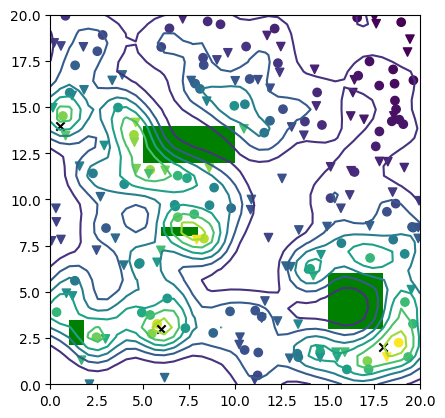

In [171]:
ax1 = gpd.GeoSeries(parks).plot(color='g')
house_df.loc[index_train,:].plot(ax=ax1,marker='o',column='satisfied_index')
house_df.loc[index_valid,:].plot(ax=ax1,marker='v',column='satisfied_index')
gpd.GeoSeries(grocery).plot(ax=ax1,color='k',marker='x')
plt.contour(gx,gy,predicted)
plt.axis([xmin, xmax, ymin, ymax])
plt.show()

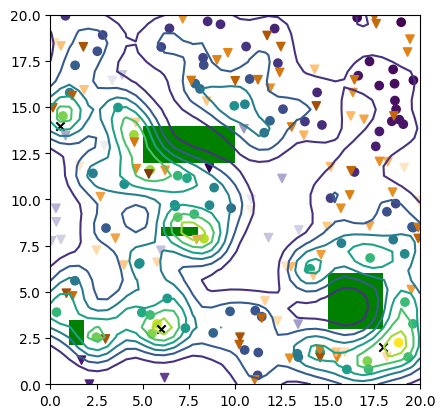

In [188]:
house_df['errors'] = house_df['satisfied_index'] - gp.predict(X)
house_df['satisfied_index_predict'] = gp.predict(X)

ax1 = gpd.GeoSeries(parks).plot(color='g')
house_df.loc[index_train,:].plot(ax=ax1,marker='o',column='satisfied_index')
gpd.GeoSeries(grocery).plot(ax=ax1,color='k',marker='x')
plt.contour(gx,gy,predicted)
house_df.loc[index_valid,:].plot(ax=ax1,marker='v',column='errors',cmap='PuOr')
plt.axis([xmin, xmax, ymin, ymax])
plt.show()

In [172]:
test_s = gpd.GeoSeries(gpd.points_from_xy(grid_points[:,0], grid_points[:,1]))
test_dist_park = test_s.distance(union_all(parks))
test_dist_grocery = test_s.distance(union_all(grocery))
y_test =  1/(1+test_dist_park) + 1/(1+test_dist_grocery)

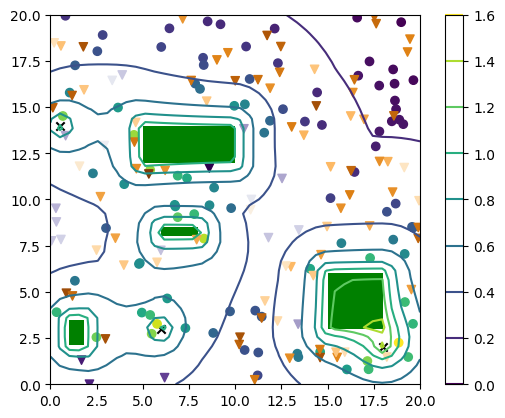

In [191]:
ax1 = gpd.GeoSeries(parks).plot(color='g')
gpd.GeoSeries(grocery).plot(ax=ax1,color='k',marker='x')
house_df.loc[index_train,:].plot(ax=ax1,marker='o',column='satisfied_index')
house_df.loc[index_valid,:].plot(ax=ax1,marker='v',column='errors',cmap='PuOr')
cax = plt.contour(gx,gy,y_test.values.reshape(GX.shape))
plt.colorbar(cax)
plt.axis([xmin, xmax, ymin, ymax])
plt.show()

In [217]:
feature_list = ["dist_park","dist_grocery","pop","hh_size"]
#feature_list = ["dist_park","dist_grocery"] # try this one
X_expanded_train = house_df.loc[index_train,
                                feature_list].values
X_expanded_valid = house_df.loc[index_valid,
                                feature_list].values

gp = GaussianProcessRegressor()
gp.fit(X_expanded_train, y_train)
print('R^2 value is {}'.format(gp.score(X_expanded_valid,y_valid)))


R^2 value is 0.0378002400580153


In [218]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_expanded_train)

X_scaled = scaler.transform(house_df.loc[:,feature_list].values)
X_scaled_train = X_scaled[index_train,:]
X_scaled_valid= X_scaled[index_valid,:]

gp = GaussianProcessRegressor()
gp.fit(X_scaled_train, y_train)
print('R^2 value is {}'.format(gp.score(X_scaled_valid,y_valid)))


R^2 value is 0.8969572691600697


In [195]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(random_state=0)
regr.fit(X_expanded_train, y_train)
print('R^2 value is {}'.format(regr.score(X_expanded_valid,y_valid)))
regr.feature_importances_


R^2 value is 0.9733040890161109


array([0.55083682, 0.43951385, 0.00304131, 0.00660802])

Make Figure 1 for the feature importance



In [ ]:
# code for Figure 1

In [205]:
# Categorical 
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(max_categories=3, sparse_output=False).fit(house_df["grocery_index"].values.reshape(-1, 1))
X_oh_grocery = ohe.transform(house_df["grocery_index"].values.reshape(-1, 1))

X_expanded2 = np.hstack([house_df.loc[:,
                                feature_list].values,X_oh_grocery])

X_expanded2_train = X_expanded2[index_train,:]
X_expanded2_valid = X_expanded2[index_valid,:]




R^2 value is 0.9735942935267495


array([0.54872853, 0.4403353 , 0.0014275 , 0.00637227, 0.00111433,
       0.00132585, 0.00069623])

In [215]:
from sklearn.linear_model import Ridge


lm = Ridge(alpha=0.01,random_state=0)
lm.fit(X_expanded2_train, y_train)

lm.fit(X_expanded2_train, y_train)
print('R^2 value is {}'.format(lm.score(X_expanded2_valid,y_valid)))
lm.coef_*np.std(X_expanded2_train)/np.std(y_train) # standardized

R^2 value is 0.6608454597920537


array([-11.09197758,  -5.91290101,  -0.04604818,   1.15054543,
        -5.36721715,   4.75517914,   0.61203801])

In [214]:
from sklearn.linear_model import ElasticNetCV

lm = ElasticNetCV(cv=5, random_state=0)
lm.fit(X_expanded2_train, y_train)
print('R^2 value is {}'.format(lm.score(X_expanded2_valid,y_valid)))
lm.coef_*np.std(X_expanded2_train)/np.std(y_train) # standardized

R^2 value is 0.6658714031680821


array([-9.98455467, -6.19812138, -0.04257283,  0.        , -0.        ,
        0.        ,  0.        ])

Figure 2

In [ ]:
# plot the standarized coefficients of the ElasticNet model

Figure 3

In [ ]:
# make a plot of the predictions   
# (colorcoding the markers by the predicted satisified index)
# with the true contour in the background
# for the random Forest model

Code Block 1

In [ ]:
# Compare the Gaussian Process across 4 sets of features and with and without scaling 
# by computing the correlation of determination (R2) on the validation set
# Feature sets:
#  1. the x and y coordinates
#  2. dist_park and dist_grocery
#  3. the x and y coordinates, household size, and population
#  4. dist_park and dist_grocery, household size, and population
#  Organize the results in a 2 by 4 table (where the row is scaling or not)

Code Block 2 

In [ ]:
# Use scikit learns nearest neighbor regression function
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# compute the correlation of determination (R2) on the validation set
# for different choices of k the number of neighbors



Figure 4

In [ ]:
# make a plot detailing the R2 performance
# the x and y coordinates